In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import math
from PIL import Image

from torch.utils.data import DataLoader, Dataset
import os
import torch.multiprocessing as mp
#from custom_dataset import CustomTriangleDataset


In [2]:
device=torch.device("mps") 
# GPU use cuda 
# Mac silicon use mps
# CPU uses cpu 

def my_transform(t):
    return (t * 2) - 1
def my_transform1(t):
    return (t + 1) / 2
def my_transform2(t):
    return t.permute(1, 2, 0)
def my_transform3(t):
    return t * 255.0
def my_transform4(t):
    return t.cpu().numpy().astype(np.uint8)


In [3]:
#we define the spacing as diffeent forms
#sin
def sinusoidal_linspace(start_point, end_point, num_points):
    t = torch.linspace(0, 1, num_points)
    return start_point + (end_point - start_point) * (1 - torch.cos(t * torch.pi)) / 2
#x^y
def power_linspace(start_point, end_point, num_points, exponent):
    t = torch.linspace(0, 1, num_points)
    return start_point + (end_point - start_point) * t**(exponent+1)
#MULTIPY BY SQRT(EXPONENT)

In [4]:
#these lines are to convert the imnage to the torch format
IMG_SHAPE=(32,32) #size of the image in pixels
transform = transforms.Compose ([ #image---> torch format
    #transforms.Resize(IMG_SHAPE),
    transforms.ToTensor(), #transfor into atensor 0,1
    transforms.Lambda(my_transform)# convert from [0,1] --> [-1,1]
])
reverse_transform= transforms.Compose ([ #torch format---> image
    transforms.Lambda(my_transform1),#
    transforms.Lambda(my_transform2),
    transforms.Lambda(my_transform3),
    transforms.Lambda(my_transform4),
    transforms.ToPILImage(),

])

In [5]:
class DiffusionModel:
    def __init__(self, start_bet=0.0001, end_bet=0.02, timesteps=300):
        self.start_bet = start_bet
        self.end_bet = end_bet
        self.timesteps = timesteps
        #here we will define the betas and alphas

        self.betas = torch.linspace(start_bet, end_bet, timesteps)
        #power_linspace(start_bet, end_bet, timesteps,10.0) 
        #sinusoidal_linspace(start_bet, end_bet, timesteps) 
        #torch.linspace(start_bet, end_bet, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_hat = torch.cumprod(self.alphas, axis = 0)


    def Forward_Diffusion(self,x_0,t, device):
        noise = torch.randn_like(x_0) #here sample as N(0,1)normal distribution
        sqrt_alphas_hat_t = self.get_index_from_list(self.alphas_hat.sqrt(),t,x_0.shape)
        sqrt_one_minus_alphas_hat_t = self.get_index_from_list(torch.sqrt(1.-self.alphas_hat),t,x_0.shape)

        mean = sqrt_alphas_hat_t.to(device)*x_0.to(device)
        variance = sqrt_one_minus_alphas_hat_t.to(device)*noise.to(device)
    
        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_hat_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_hat), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_hat_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1,t.cpu())
        return result.reshape(batch_size, *((1,) *(len(x_shape)-1))).to(t.device)



In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

class UNet(nn.Module):
    def __init__(self, img_channels = 1, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [7]:
class CustomTriangleDataset(Dataset):
    def __init__(self, root_dir, start_index, end_index, transform):
        self.root_dir = root_dir
        self.start_index = start_index
        self.end_index = end_index
        self.transform = transform

        self.file_list = sorted(os.listdir(self.root_dir))

    def __len__(self):
        return self.end_index - self.start_index

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx + self.start_index])
        image = np.load(img_name)#= np.load("triagle_"+str(i)+".npy")
        #image = image.convert("L") #convert the image in B/W grey scale
        if self.transform:
            image = self.transform(image)

        return image

In [8]:
# Define the path to your triangle samples folder
triangle_samples_path = "/Users/luismartinezrojas/Documents/denoising/array_100_triangle"
verify_sample_pat = "/Users/luismartinezrojas/Documents/denoising/array_100_test_triangle"

# Define your batch size
BATCH_SIZE = 20
BATCH_SIZE_verify = 20

# Set the start and end indices for your desired range (triangle_1.jpeg to triangle_200.jpeg)
start_index =0
end_index =  9999 #9999
end_index_verify =  49

# Create the custom triangle dataset
trainset = CustomTriangleDataset(root_dir=triangle_samples_path,
                                 start_index=start_index,
                                 end_index=end_index,
                                 transform=transform)

#create the cutom triangle 
verifyset=CustomTriangleDataset(root_dir=verify_sample_pat,
                                 start_index=start_index,
                                 end_index=end_index_verify,
                                 transform=transform)


In [9]:
# Create the data loader
trainloader = DataLoader(trainset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0,
                         drop_last=True)
verifyloader = DataLoader(verifyset,
                         batch_size=BATCH_SIZE_verify,
                         shuffle=True,
                         num_workers=0,
                         drop_last=True)

In [10]:
diffusion_model=DiffusionModel()

NO_EPOCHS = 100
PRINT_FREQUENCY = 9
LR = 0.001
VERBOSE = False

unet = UNet(labels=False).to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [11]:
loss_array_min=[]
loss_array_max=[]
loss_array_mean=[]

loss_val_array_min=[]
loss_val_array_max=[]
loss_val_array_mean=[]

In [ ]:

for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []

    for batch in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.Forward_Diffusion(batch, t, device)
        predicted_noise = unet(batch_noisy, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    for batch in verifyloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE_verify,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.Forward_Diffusion(batch, t, device) 
        predicted_noise = unet(batch_noisy, t)

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())
    
    loss_array_mean.append(np.mean(mean_epoch_loss))
    loss_array_min.append(np.min(mean_epoch_loss))
    loss_array_max.append(np.max(mean_epoch_loss))
    
    loss_val_array_mean.append(np.mean(mean_epoch_loss_val))
    loss_val_array_min.append(np.min(mean_epoch_loss_val))
    loss_val_array_max.append(np.max(mean_epoch_loss_val))
    print(epoch)
    if epoch > 70 and epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
        
        save_dir = f"size{BATCH_SIZE}/epoch{NO_EPOCHS}"
        # Ensure the directory exists, or create it if it doesn't
        os.makedirs(save_dir, exist_ok=True)
        torch.save(unet.state_dict(), os.path.join(save_dir, f"step_epoch{epoch}"))

In [ ]:
import csv
file_name = "vectors_data.csv"

# Create and open the CSV file in write mode
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    # Write the headers (optional, you can omit this if you don't need headers)
    headers = ['loss_min', 'loss_mean', 'loss_max', 'verify_min', 'verify_mean', 'verify_max']
    writer.writerow(headers)
    
    # Zip the six vectors together and write each row to the CSV file
    for row in zip(loss_array_min, loss_array_mean, loss_array_max, loss_val_array_min, loss_val_array_mean, loss_val_array_max):
        writer.writerow(row)

print("Vectors saved to", file_name)

In [77]:

unet = UNet(labels=False)
unet.load_state_dict(torch.load(("/Users/luismartinezrojas/Documents/denoising/size200/x10_epoch100/step_epoch99"))) #/content/drive/MyDrive/Epochs_training/epochsBS1000/

<All keys matched successfully>

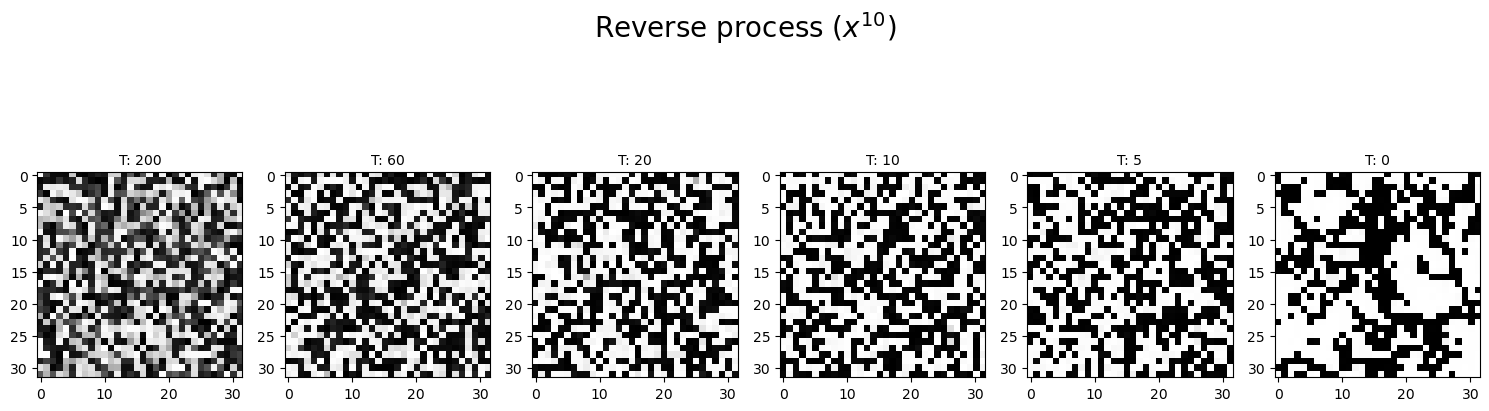

In [78]:
            
NO_images_to_show = 6  # You can change this to your desired number
f, ax = plt.subplots(1, NO_images_to_show, figsize=(15, 5))  # Adjust figsize as needed
idx=0
print_ima=[200,60,20,10,5,0]
with torch.no_grad():
    img = torch.randn((1, 1) + IMG_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval().to(device))
        if i in print_ima:

            ax[idx].imshow(reverse_transform(img[0]),cmap="gray")
            ax[idx].set_title(f"T: {i}", fontsize=10)
            idx= idx+1


# Set a single title for all subplots
f.suptitle(r"Reverse process ($x^{10}$)", fontsize=20)  # Adjust fontsize as needed

plt.tight_layout()  # Automatically adjusts the spacing

plt.savefig("noisy_triangle_x10.jpeg")
plt.show()

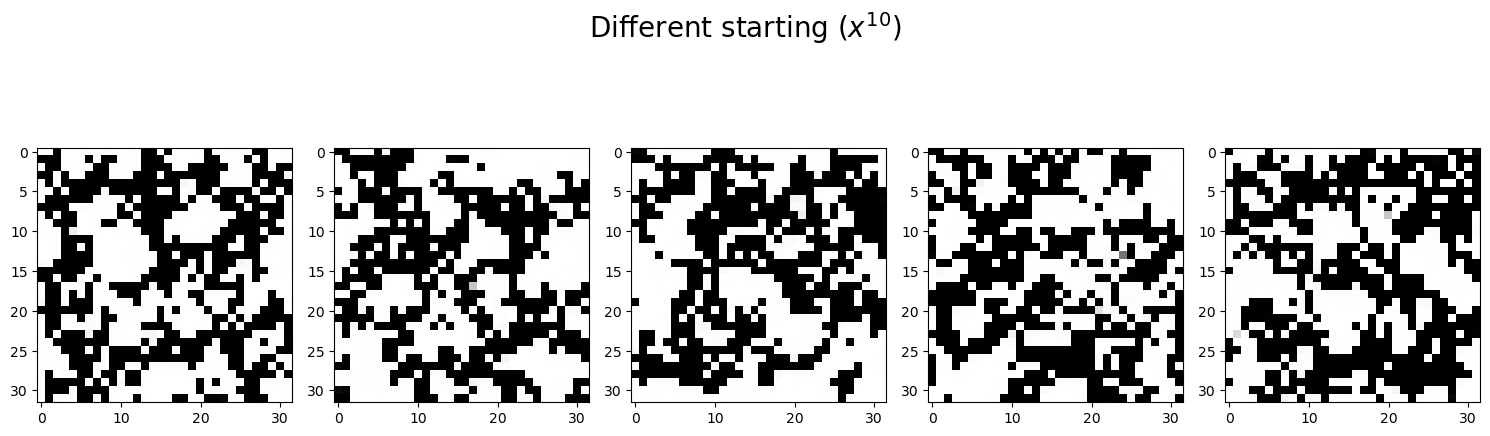

In [79]:
NUM_DISPLAY_IMAGES=5
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize = (15,5))
with torch.no_grad():
  img = torch.randn((NUM_DISPLAY_IMAGES, 1) + IMG_SHAPE).to(device)
  for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,),i, dtype=torch.long, device=device)
    img= diffusion_model.backward(x=img, t=t, model=unet.eval().to(device))
  for idx, img in enumerate(img):
    ax[idx].imshow(reverse_transform(img),cmap="gray")
    ax[idx].set_title(f"", fontsize = 10)

f.suptitle(r"Different starting ($x^{10}$)", fontsize=20)  # Adjust fontsize as needed

plt.tight_layout()  # Automatically adjusts the spacing
plt.savefig("reconstruccion_x10.png")

In [ ]:
start_bet=1e-4
end_bet=0.02
timesteps=300

pow10=power_linspace(start_bet, end_bet, timesteps,10.0) 
pow2=power_linspace(start_bet, end_bet, timesteps,2.0) 
pow15=power_linspace(start_bet, end_bet, timesteps,1.5) 

sen=sinusoidal_linspace(start_bet, end_bet, timesteps) 
lineal=torch.linspace(start_bet, end_bet, timesteps)

In [ ]:
plt.plot(lineal, label="Linear")
plt.plot(sen, label="Sine")
plt.plot(pow15, label="Power 1.5")
plt.plot(pow2, label="Power 2")
plt.plot(pow10, label="Power 10")

plt.ylabel("Noise")
plt.xlabel("Time step")

# Adding a legend
plt.legend()

# Show the plot
plt.savefig("noise_aded.jpeg")